# Modelo de tarifación Airbnb en Seattle

Modificado en Oct 21, 2020

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, optimizers, regularizers
from numpy.random import seed
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
import math
import numpy as np
seed(123)
print(tf.__version__)

2.1.0


## Dataset de entrada

In [2]:
dataset=pd.read_csv('C:\\Users\\Andrea\\Desktop\\Datasets\\Airbnb Seattle\\Archivos\\Listings_kmeans.csv')
print('El dataset de entrada contiene', len(dataset.columns), 'columnas', 'y', len(dataset), 'filas')

El dataset de entrada contiene 69 columnas y 4917 filas


In [3]:
dataset=dataset.drop(['Unnamed: 0'], axis=1) #,'k_means'
dataset=dataset[ (dataset['price']<1000) & (dataset['price']>0)] 
dataset['price'] = np.log(dataset['price'])

In [4]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(dataset)

,host_acceptance_rate,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,Apartment,Guest suite,House,Other,Entire home/apt,Hotel room,Private room,Shared room,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60,Real Bed,Self check-in,Cooking basics,First aid kit,Stove,Free street parking,Bed linens,Oven,Private entrance,Free parking on premises,Dishwasher,Family/kid friendly,Air conditioning,Luggage dropoff allowed,Cable TV,Indoor fireplace,Elevator,Gym,Pets allowed,Lockbox,Safety card,24-hour check-in,Bathtub,k_means
0,87.0,1.0,0.0,47.61082,-122.29082,9,4.0,5.690359,500.0,250.0,8,25.0,1,1125,0,0,14,30,32,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0.22,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,90.0,1.0,1.0,47.55017,-122.31937,2,2.0,4.127134,100.0,20.0,1,15.0,2,180,30,60,90,365,148,93.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,1,1,1.23,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,91.0,0.0,0.0,47.51284,-122.33587,13,9.0,5.298317,350.0,85.0,1,0.0,1,90,14,36,60,330,2,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,0,2.00,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
4916,93.0,0.0,0.0,47.63913,-122.34293,3,0.0,3.555348,0.0,15.0,1,5.0,1,60,0,0,0,0,2,90.0,10.0,8.0,10.0,10.0,10.0,10.0,1,0,0,0,2.00,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


## Normalizando

In [5]:
def min_max(x): 
    return (x-x.min())/(x.max()-x.min())

In [6]:
normed_data = min_max(dataset)

In [7]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

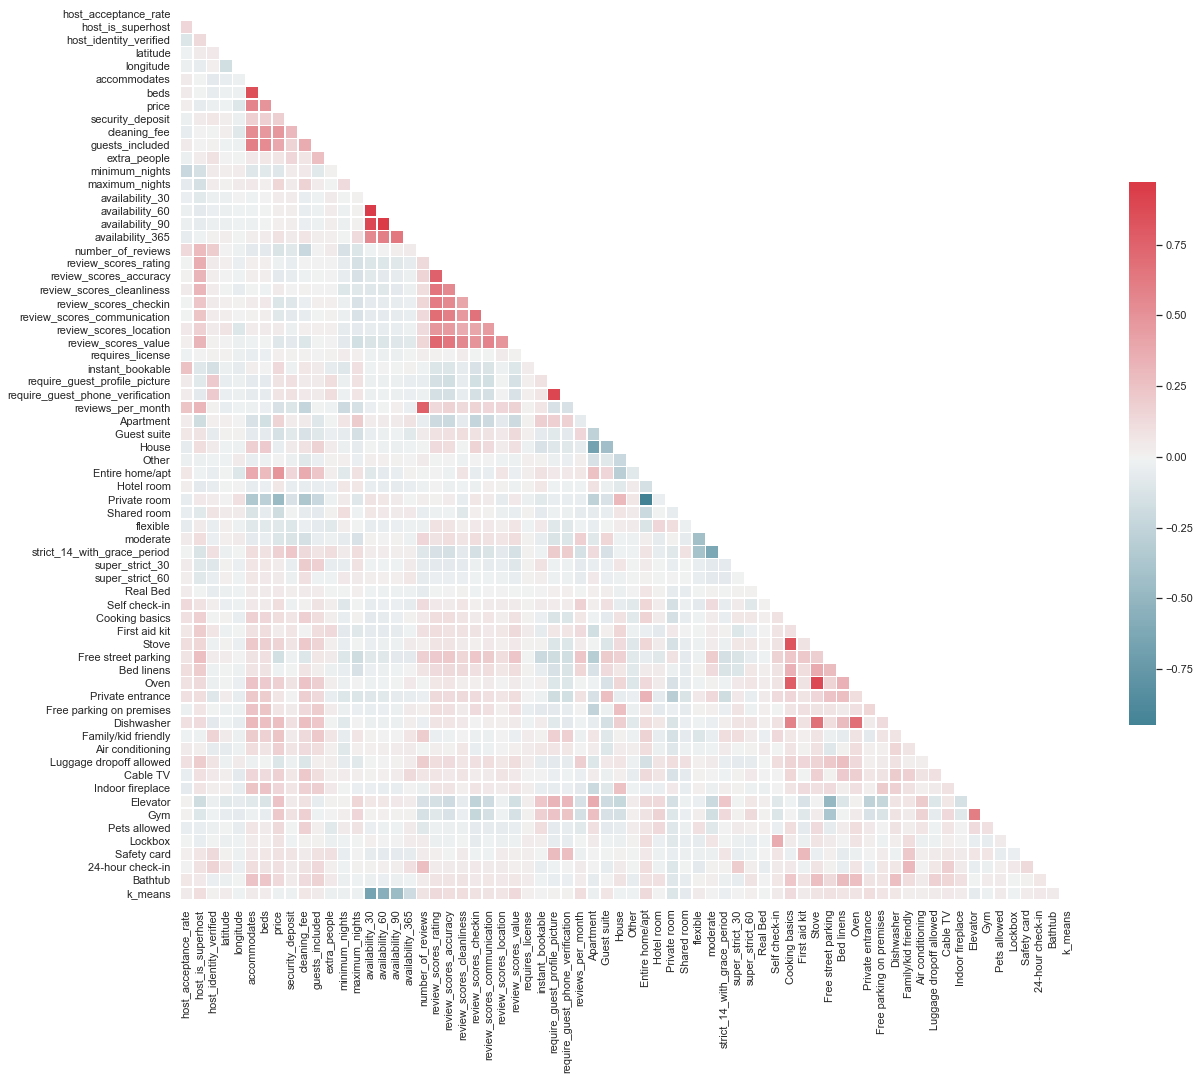

In [8]:
multi_collinearity_heatmap(normed_data, figsize=(20,20)) #Se eliminan: 1. cleaning y security, guest, extra people 2. Reviews, 3. Flexible, 4. Cocina, 5. Ascensor

In [9]:
normed_data=normed_data.drop([ 'guests_included', 'extra_people', 'availability_60', 'availability_90', 'availability_365',
'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
       'review_scores_value','flexible', 'Oven', 'Dishwasher', 'Stove', 'Elevator' , 
                             'number_of_reviews', 'security_deposit',
        'super_strict_30', 'super_strict_60','Other'                     
                              
                             ], axis=1) #'number_of_reviews' 'security_deposit',

In [10]:
normed_train_data= normed_data.sample(frac=0.8,random_state=0)
normed_test_data = normed_data.drop(normed_train_data.index)

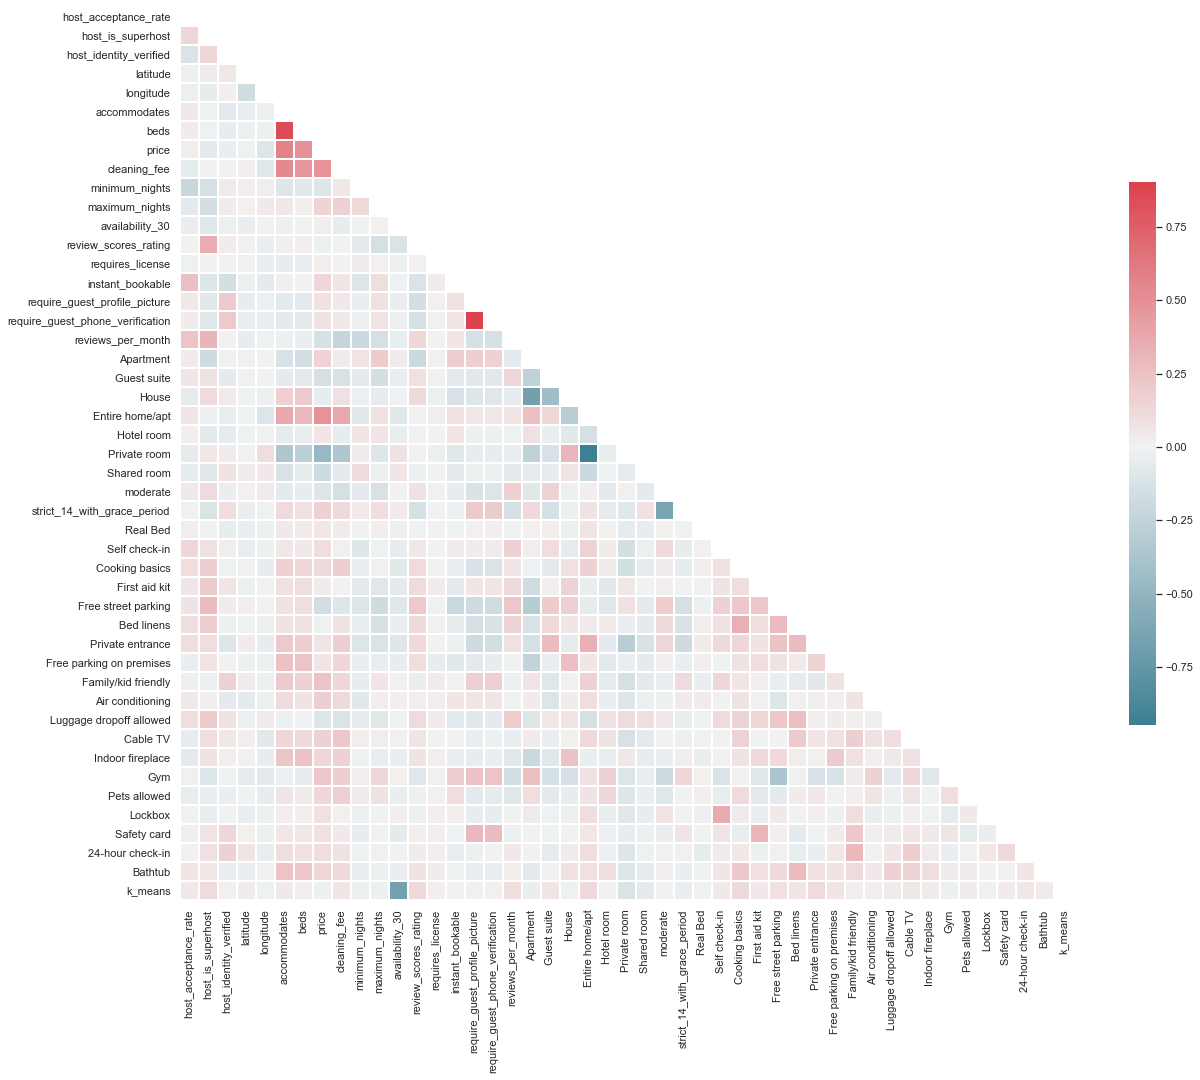

In [11]:
#normed_test_data.columns
multi_collinearity_heatmap(normed_data, figsize=(20,20)) #Se eliminan: 1. cleaning y security, guest, extra people

# Separando caracteristicas y etiquetas

In [12]:
train_labels = normed_train_data.pop('price')
test_labels = normed_test_data.pop('price')

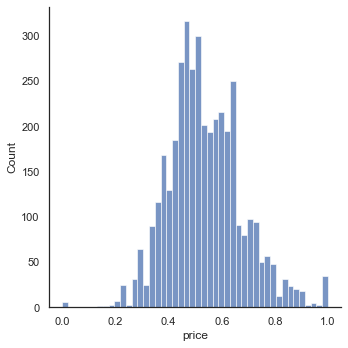

In [13]:
sns.displot(train_labels)

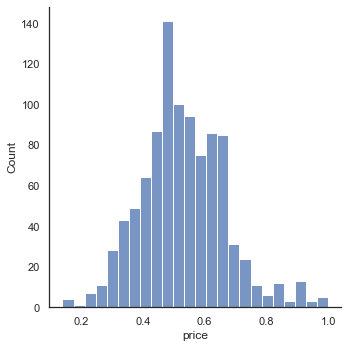

In [14]:
sns.displot(test_labels)

# El modelo

### Construye el modelo

In [15]:
# ,kernel_regularizer=regularizers.l2(0.05)
# La mejor que llevo es 512, 256, dropout 0.3, adam 0.001 y sin regularizador
def build_model():  
  model = keras.Sequential([
    layers.Dense(512, activation='relu',input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(0.01) #0.1

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model = build_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               24064     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 155,649
Trainable params: 155,649
Non-trainable params: 0
_________________________________________________________________


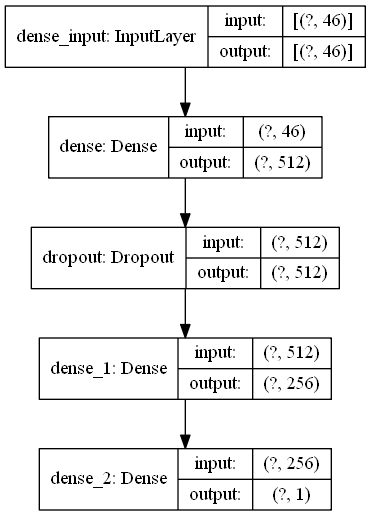

In [18]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.01929578],
       [-0.15104735],
       [-0.05235286],
       [-0.21430191],
       [-0.12044351],
       [-0.10656478],
       [ 0.09112488],
       [-0.09088732],
       [-0.01574047],
       [-0.06561871]], dtype=float32)

### Entrenamiento del modelo

In [20]:
# Display training progress by printing a single dot for each completed epoch
time_start = time.time()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

time_end = time.time()
print(f"\nTiempo de ejecución: {round((time_end - time_start)/60,1)} minutos")


....................................................................................................
....................................................................................................
Tiempo de ejecución: 1.5 minutos


In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,0.007520,0.065455,0.007520,0.007830,0.067314,0.007830,195
196,0.007156,0.063737,0.007156,0.008000,0.067733,0.008000,196
197,0.007096,0.063693,0.007096,0.008500,0.070237,0.008500,197
198,0.006939,0.063298,0.006939,0.007471,0.064993,0.007471,198
199,0.007498,0.065451,0.007498,0.010256,0.077644,0.010256,199


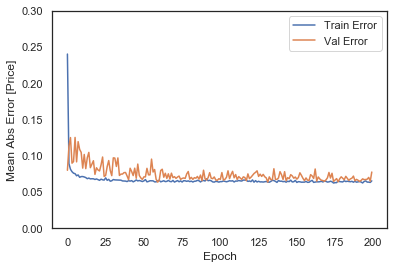

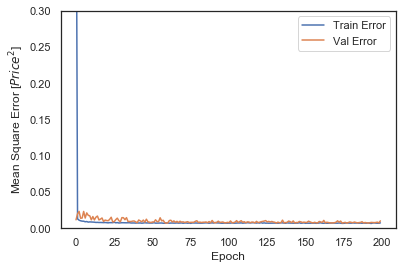

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.3])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.3])
  plt.legend()
  plt.show()


plot_history(history)


........................................................

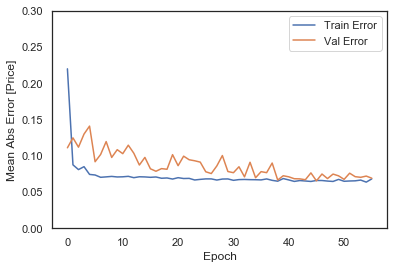

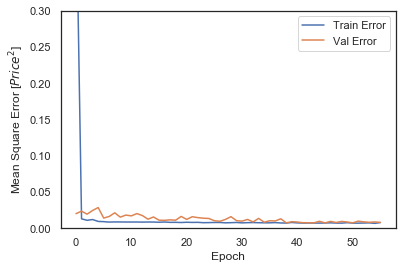

In [23]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

983/983 - 0s - loss: 0.0077 - mae: 0.0669 - mse: 0.0077
Testing set Mean Abs Error:  0.07


## Predicciones

983


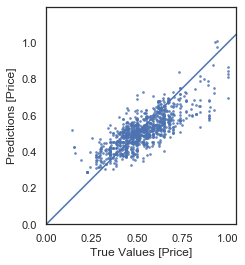

In [25]:
test_predictions = model.predict(normed_test_data).flatten()
print(len(test_predictions))
plt.scatter(test_labels, test_predictions,alpha=0.7,s=3)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-0,plt.xlim()[1]])
plt.ylim([-0,plt.ylim()[1]])
_ = plt.plot([-1, 10], [-1, 10]) #El modelo subestima para precios mayores a 200 dolares

983


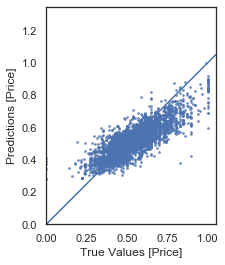

In [26]:
train_predictions = model.predict(normed_train_data).flatten()
print(len(test_predictions))
plt.scatter(train_labels, train_predictions,alpha=0.7,s=3)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-1, 10], [-1, 10])

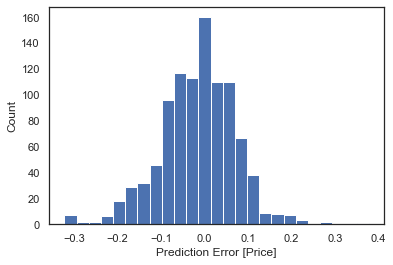

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")

In [28]:
y_test_pred = model.predict(normed_test_data)
y_train_pred = model.predict(normed_train_data)
print("Training MSE:", round(mean_squared_error(train_labels, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(test_labels, y_test_pred),4))
print("\nTraining r2:", round(r2_score(train_labels, y_train_pred),4))
print("Validation r2:", round(r2_score(test_labels, y_test_pred),4))

Training MSE: 0.0071
Validation MSE: 0.0077

Training r2: 0.637
Validation r2: 0.59


Training MSE: 0.0036
Validation MSE: 0.0074

Training r2: 0.8173
Validation r2: 0.6062